In [3]:
import pandas as pd
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [4]:
tweets_main = pd.read_csv(f'../datasets/tweets_full.csv')
analyzer = SentimentIntensityAnalyzer()

In [88]:
company = "AMZN"
tweets = tweets_main[tweets_main["ticker_symbol"] == company].copy().reset_index(drop=True)

In [193]:
def clean_body(col):
    import re

    # usun urle
    # usun hashtagi
    pattern_url = r"https?://[a-z.]+/[?a-z0-9./]+"
    pattern_hash = r"#"
    col = re.sub(pattern_url, "", col, flags=re.I)
    col = re.sub(pattern_hash, "", col, flags=re.I)

    return col


def convert_dict_keyval_to_col(dict, key):
    new_col = []
    for i in dict:
        new_col.append(i[key])
    return new_col


def calc_sentiment(df, other_cols):
    df = df.copy()
    sent = df["body"].apply(analyzer.polarity_scores)

    sentiment_val = pd.DataFrame()
    sentiment_val["pos"] = convert_dict_keyval_to_col(sent, "pos")
    sentiment_val["neu"] = convert_dict_keyval_to_col(sent, "neu")
    sentiment_val["neg"] = convert_dict_keyval_to_col(sent, "neg")
    sentiment_val["comp"] = convert_dict_keyval_to_col(sent, "compound")

    for col in other_cols:
        sentiment_val[col] = df[col]

    return sentiment_val


def create_weight(df):
    pass


def calc_weight(tweet):
    retweets = tweet.retweet_num
    likes = tweet.like_num
    comms = tweet.comment_num
    weight = 0
    if tweet.retweet_num == 0:
        weight = 1 + 0.05 * likes + 0.2 * comms
    else:
        weight = retweets * (1 + 0.05 * likes + 0.2 * comms)
    return weight


def calc_weight_2(tweet):
    retweets = tweet.retweet_num
    likes = tweet.like_num
    comms = tweet.comment_num
    weight = 0
    if tweet.retweet_num == 0:
        weight = 1 + 0.05 * likes + 0.2 * comms
    else:
        weight = 1 + 0.5 * retweets + 0.05 * likes + 0.2 * comms
    return weight


def explore_weights(df, col):
    print(df[df[col] == max(df[col])].body)
    print(tweets[col].describe(percentiles=[0.05 * (i + 1) for i in range(19)]))


def percentage_weights(df, col):
    base = round(len(df.loc[df[col] == 1]) / len(df), 3) * 100
    one_three = len(df.loc[(df[col] > 1) & (df[col] < 3)]) / len(tweets) * 100
    three_five = len(df.loc[(df[col] > 3) & (df[col] < 10)]) / len(tweets) * 100

    print("Worth 1 tweet:", round(base, 3))
    print("Worth 1 to 3 tweets:", round(one_three, 3))
    print("Worth 3 to 5 tweets:", round(three_five, 3))
    print("Total: ", round(base, 3) + round(one_three, 3) + round(three_five, 3))

In [177]:
tweets["weight"] = tweets.apply(calc_weight, axis=1)
tweets["weight2"] = tweets.apply(calc_weight_2, axis=1)

In [154]:
base = round(len(tweets.loc[tweets["weight"] == 1]) / len(tweets), 3) * 100
one_three = (
    round(
        len(tweets.loc[(tweets["weight"] > 1) & (tweets["weight"] < 3)]) / len(tweets),
        3,
    )
    * 100
)
three_five = (
    round(
        len(tweets.loc[(tweets["weight"] > 3) & (tweets["weight"] < 10)]) / len(tweets),
        3,
    )
    * 100
)
print(base, one_three, three_five, base + one_three + three_five)

64.7 30.7 2.9000000000000004 98.30000000000001


In [188]:
percentage_weights(tweets, "weight")

Worth 1 tweet: 64.7
Worth 1 to 3 tweets: 30.692
Worth 3 to 5 tweets: 2.937
Total:  98.329


In [189]:
percentage_weights(tweets, "weight2")

Worth 1 tweet: 61.2
Worth 1 to 3 tweets: 35.32
Worth 3 to 5 tweets: 2.795
Total:  99.31500000000001


In [194]:
explore_weights(tweets, "weight2")

297997    Will We Hold It Wednesday - Nasdaq 5,400 Editi...
Name: body, dtype: object
count    718715.000000
mean          1.402858
std           3.743355
min           1.000000
5%            1.000000
10%           1.000000
15%           1.000000
20%           1.000000
25%           1.000000
30%           1.000000
35%           1.000000
40%           1.000000
45%           1.000000
50%           1.000000
55%           1.000000
60%           1.000000
65%           1.050000
70%           1.050000
75%           1.150000
80%           1.300000
85%           1.500000
90%           1.700000
95%           2.400000
max         511.500000
Name: weight2, dtype: float64


In [192]:
explore_weights(tweets, "weight")

255699    Sometimes hard to wrap your head around $AMZN
Name: body, dtype: object
count    718715.000000
mean          3.628926
std         114.873287
min           1.000000
5%            1.000000
10%           1.000000
15%           1.000000
20%           1.000000
25%           1.000000
30%           1.000000
35%           1.000000
40%           1.000000
45%           1.000000
50%           1.000000
55%           1.000000
60%           1.000000
65%           1.050000
70%           1.050000
75%           1.050000
80%           1.100000
85%           1.200000
90%           1.400000
95%           2.600000
max       31524.800000
Name: weight, dtype: float64


1.3


<AxesSubplot:>

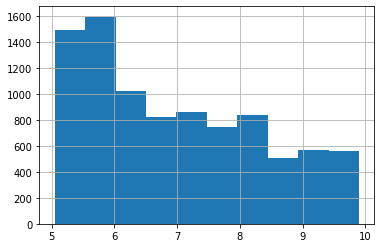

In [144]:
x = tweets.loc[(tweets["weight"] > 5) & (tweets["weight"] < 10), "weight"]
print(round(len(x)/len(tweets), 3)*100)
x.hist()

<AxesSubplot:>

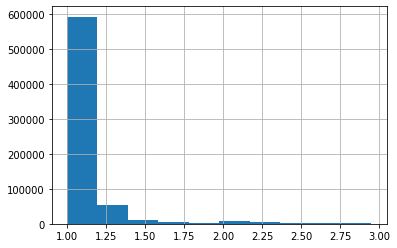

In [121]:
tweets.loc[tweets["weight"] < 3, "weight"].hist()

In [19]:
calc_weight(tweets.iloc[0])

2.2

In [ ]:
tweets_clean = tweets['body'].apply(clean_body)

In [ ]:
weighted_mean = lambda x: np.average()